# JigsawHSI for Hyper Spectral Image Classification

**Author:** Jaime MORAGA
**ORCID :** https://orcid.org/0000-0003-4483-9900

# Select dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/JigsawHSI
!pip install spectral

/content/drive/MyDrive/JigsawHSI
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 9.6 MB/s eta 0:00:00


In [ ]:
## GLOBAL VARIABLES
dataset = 'IP_99.74'
# dataset = 'IP_99.74'
# dataset = 'PU_100'
# dataset = 'SA_100'


# Initialize all random functions with same seed

In [ ]:
import os
# Use this before loading tensorflow
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # Block INFO messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Block INFO and WARNING messages
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Block INFO, WARNING and ERROR messages
# https://www.tensorflow.org/api_docs/python/tf/autograph/set_verbosity
os.environ["AUTOGRAPH_VERBOSITY"] = "0"
import tensorflow as tf
tf.get_logger().setLevel("WARNING")

import random
import numpy as np

def random_seed():
    return os.urandom(42)

def reset_seeds(random_state = 42):
    try:
        tf.keras.utils.set_random_seed(random_state) # This resets all
        return 0
    except:
        random.seed(random_state)
        np.random.seed(random_state)
        tf.random.set_seed(random_state) # Tensorflow 2.9+
    try:
        from tensorflow import set_random_seed # Tensorflow 1.x
        set_random_seed(random_state)
        return 2
    except:
        pass
    return 1

max_gpus = len(tf.config.list_physical_devices('GPU'))

"""
Reset all random seeds
"""
r = reset_seeds(345)
del r

# Import libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis, NMF
from sklearn.decomposition import PCA, TruncatedSVD
from operator import truediv

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

#!pip install spectral
import spectral

# Define functions

## JigsawHSI definition

In [ ]:
from keras.utils import Sequence
from keras.models import Model, Sequential
from keras.layers import Input, Concatenate
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,Conv3D,BatchNormalization,add,Reshape
from keras.layers import Activation, Flatten, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import Adadelta, SGD, Adam, Nadam, Adagrad, Adamax

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import utils as np_utils

from skimage.transform import rotate
from keras.models import clone_model
from keras.utils import plot_model
#from keras.utils.multi_gpu_utils import multi_gpu_model

def jigsaw_m2( input_net, first_layer = None , internal_size = 13):
    # Creates internal filters as Inception: 1x1, 3x3, 5x5 ..., nxn 
    # Where n = internal_size
    # jigsaw_t1_1x1 = Conv2D(256, (1,1), padding='same', activation = 'relu', 
    #
                            # kernel_regularizer = l2(0.002))(input_net)
    jigsaw_t1_1x1 = input_net
    jigsaw_t1_3x3_reduce = Conv2D(96, (1,1), padding='same', activation = 'relu', 
                                  kernel_regularizer = l2(0.002))(input_net)
    jigsaw_t1_3x3 = Conv2D(128, (3,3), padding='same', activation = 'relu', 
                           kernel_regularizer = l2(0.002))(jigsaw_t1_3x3_reduce) # , name="i_3x3"
    if (internal_size >= 5):
        jigsaw_t1_5x5_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                      kernel_regularizer = l2(0.002))(input_net)
        jigsaw_t1_5x5 = Conv2D(128, (5,5), padding='same', activation = 'relu', 
                               kernel_regularizer = l2(0.002))(jigsaw_t1_5x5_reduce) # , name="i_5x5"
    if (internal_size >= 7):
        jigsaw_t1_7x7_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                      kernel_regularizer = l2(0.002))(input_net)
        jigsaw_t1_7x7 = Conv2D(128, (7,7), padding='same', activation = 'relu', 
                               kernel_regularizer = l2(0.002))(jigsaw_t1_7x7_reduce) # , name="i_7x7"
    if (internal_size >= 9):
        jigsaw_t1_9x9_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                      kernel_regularizer = l2(0.002))(input_net)
        jigsaw_t1_9x9 = Conv2D(64, (9,9), padding='same', activation = 'relu', 
                               kernel_regularizer = l2(0.002))(jigsaw_t1_9x9_reduce) # , name="i_9x9"
    if (internal_size >= 11):
        jigsaw_t1_11x11_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                        kernel_regularizer = l2(0.002))(input_net)
        jigsaw_t1_11x11 = Conv2D(64, (11,11), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(0.002))(jigsaw_t1_11x11_reduce) # , name="i_11x11"
    if (internal_size >= 13):
        jigsaw_t1_13x13_reduce = Conv2D(16, (1,1), padding='same', activation = 'relu', 
                                        kernel_regularizer = l2(0.002))(input_net)
        jigsaw_t1_13x13 = Conv2D(64, (13,13), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(0.002))(jigsaw_t1_13x13_reduce) # , name="i_13x13"
    jigsaw_t1_pool = MaxPooling2D(pool_size=(3,3), strides = (1,1), padding='same')(input_net)
    jigsaw_t1_pool_proj = Conv2D(32, (1,1), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(0.002))(jigsaw_t1_pool)
    jigsaw_list = [jigsaw_t1_1x1, jigsaw_t1_3x3]
    if (internal_size >= 5):
        jigsaw_list.append(jigsaw_t1_5x5)
    if (internal_size >= 7):
        jigsaw_list.append(jigsaw_t1_7x7)
    if (internal_size >= 9):
        jigsaw_list.append(jigsaw_t1_9x9)
    if (internal_size >= 11):
        jigsaw_list.append(jigsaw_t1_11x11)
    if (internal_size >= 13):
        jigsaw_list.append(jigsaw_t1_13x13)
    jigsaw_list.append(jigsaw_t1_pool_proj)
    if first_layer is not None:
        jigsaw_t1_first = Conv2D(96, (1,1), padding='same', activation = 'relu', 
                                 kernel_regularizer = l2(0.002))(first_layer)
        jigsaw_list.append(jigsaw_t1_first)
    jigsaw_t1_output = Concatenate(axis = -1)(jigsaw_list)
    return jigsaw_t1_output

def jigsaw_m_end(input_net, num_classes, first_layer = None):
    avg_pooling = AveragePooling2D(pool_size=(3,3), strides=(1,1), name='avg_pooling')(input_net)
    flat = Flatten()(avg_pooling)
    flat = Dense(32, kernel_regularizer=l2(0.002))(flat)
    flat = Dropout(0.4)(flat)
    if first_layer is not None:
        input_pixel = Flatten()(first_layer)
        input_pixel = Dense(16, kernel_regularizer=l2(0.002))(input_pixel)
        input_pixel = Dropout(0.2)(input_pixel)
        input_pixel = Dense(16, kernel_regularizer=l2(0.002))(input_pixel)
        input_pixel = Dropout(0.2)(input_pixel)
        flat = Concatenate(axis = -1)([input_pixel, flat])
    flat = Dense(32, kernel_regularizer=l2(0.002))(flat)
    avg_pooling = Dropout(0.4)(flat)
    loss3_classifier = Dense(num_classes, kernel_regularizer=l2(0.002))(avg_pooling)
    loss3_classifier_act = Activation('softmax', name='prob')(loss3_classifier)
    return loss3_classifier_act

# 构建R_HybridSN模块

In [ ]:
def R_HybridSN_block(input_layer):
    conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',strides=(1,1,1),padding='same',kernel_regularizer = l2(0.002))(input_layer)
    conv_layer2 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu',strides=(1,1,1),padding='same',kernel_regularizer = l2(0.002))(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(5, 5, 5), activation='relu',strides=(1,1,1),padding='same',kernel_regularizer = l2(0.002))(input_layer)
    return add([conv_layer2,conv_layer3])

In [ ]:
def R_HybridSN_model(input_layer):
  conv1 =Conv3D(filters=4,kernel_size=(1,1,3),strides=(1,1,1),padding='same',activation='relu',kernel_regularizer = l2(0.002))(input_layer)
  conv1 = BatchNormalization()(conv1)
  conv2 = Conv3D(filters=4,kernel_size=(3,3,3),strides=(1,1,1),padding='same',activation='relu',kernel_regularizer = l2(0.002))(input_layer)
  conv2 = BatchNormalization()(conv2)
  conv3 = Conv3D(filters=4,kernel_size=(5,5,3),strides=(1,1,1),padding='same',activation='relu',kernel_regularizer = l2(0.002))(input_layer)
  conv3 = BatchNormalization()(conv3)
  conv_out = Concatenate(axis = -1)([conv1,conv2,conv3])
  conv4 = R_HybridSN_block(conv_out)
  conv5 = BatchNormalization()(conv4)
  conv6 = R_HybridSN_block(conv5)
  conv7 = BatchNormalization()(conv6)
  conv3d_shape = conv7.shape
  conv8 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv7)
  #conv9 = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer = l2(0.002))(conv8)
  conv9 = BatchNormalization()(conv8)
  return conv9

In [ ]:
# Builds model
def build_jigsawHSI(internal_size=13, num_classes=2, image_dim = (19, 19, 7), dimension_filters = None, verbose=1):
    my_input = Input( shape=image_dim )
    RHY = R_HybridSN_model(my_input)
    # Not needed for SA
    if ((dimension_filters is None) or (dimension_filters < 1)):
        conv1 = None
    else:
        conv1 = Conv2D(dimension_filters, (1,1), padding='same', activation = 'relu',
                      kernel_regularizer = l2(0.002), name='spectral_filter')(RHY)
    if(verbose>0):
        print(f"*** Building Jigsaw with up to {internal_size}x{internal_size} kernels")
    # One jigsaw module(s)
    jigsaw_01 = jigsaw_m2( RHY if conv1 is None else conv1, internal_size = internal_size )
    # For SA, the next two lines must be uncommented
    # jigsaw_01 = jigsaw_m2( jigsaw_01, first_layer=my_input, internal_size = internal_size )
    # jigsaw_01 = jigsaw_m2( jigsaw_01, internal_size = internal_size )
    
    # Attaches end to jigsaw modules, returns class within num_classes
    loss3_classifier_act = jigsaw_m_end(jigsaw_01,
                                    num_classes = num_classes,
                                    first_layer = my_input ) # testing num_classes
    model3 = Model( inputs = my_input, outputs = loss3_classifier_act )
    model3.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
    return model3


In [ ]:
# class Kernel3D:
#     def __init__(self, rows=3, cols=3, shape='rect', radius=None, no_value=np.NaN):
#         if shape == 'circle':
#             self.rows = 2*radius+1
#             self.cols = 2*radius+1
#             self.mask = self.round_mask(radius)
#             self.row_buffer = radius
#             self.col_buffer = radius
#         else:
#             self.rows = rows
#             self.cols = cols
#             self.mask = np.ones((rows, cols))
#             self.row_buffer = int((rows-1)/2)
#             self.col_buffer = int((cols-1)/2)
#         self.mask = self.mask[np.newaxis, :, :]
#         self.no_value = no_value
#         assert((rows%2) == 1)
#         assert((cols%2) == 1)

#     def round_mask(self, radius):
#         diameter = 2*radius+1
#         mask = np.empty((diameter, diameter,))
#         mask[:] = self.no_value
#         sq_radius = radius**2
#         for i in range(diameter):
#             for j in range(diameter):
#                 if ((i-radius)**2+(j-radius)**2) <= sq_radius:
#                     mask[i, j] = 1
#         return mask

#     def getSubset(self, matrix, row, column):
#         m_rows = matrix.shape[1]
#         assert (row >= self.row_buffer), f"Out of bounds row {row}, from {m_rows}"
#         assert (row < (m_rows-self.row_buffer)), f"Out of bounds row {row}, from {m_rows}"
#         m_cols = matrix.shape[2]
#         assert((column >= self.col_buffer) and (column < (m_cols-self.col_buffer))), f"Out of bounds column {column}, from {m_cols}"
#         row_start = row-self.row_buffer
#         row_end = row+self.row_buffer
#         column_start = column-self.col_buffer
#         column_end = column+self.col_buffer
#         small_matrix = matrix[:, row_start:row_end+1, column_start:column_end+1]
#         return small_matrix*self.mask

# class GeoTiffSlicer(object):
#     def __init__(self, land_matrix, kernel_rows=None, kernel_cols=None,
#                  kernel_shape='rect', kernel_radius=0, no_value = np.NaN):
#         # (w, h, d) input tiff expected
#         # (d, h, w) input tiff from rasterio must be transposed before calling this class
#         if kernel_cols is None:
#             kernel_cols = kernel_rows
#         assert(kernel_cols < land_matrix.shape[2])
#         assert(kernel_rows < land_matrix.shape[1])
#         assert((kernel_shape == 'rect') or (kernel_shape == 'circle'))
#         assert(kernel_radius>=0)
#         if kernel_shape == 'rect':
#             self.kernel = Kernel3D(rows=kernel_rows, cols=kernel_cols)
#         else:
#             self.kernel = Kernel3D(radius=kernel_radius,
#                                    shape=kernel_shape,
#                                    no_value=no_value)
#             kernel_rows = kernel_cols = 2*kernel_radius+1
#         self.kernel_rows = kernel_rows
#         self.kernel_cols = kernel_cols
#         self.land_matrix = land_matrix
#         self.land_matrix_channels, self.land_matrix_cols, self.land_matrix_rows = land_matrix.shape
#         self.land_matrix_cols = land_matrix.shape[2]
#         self.land_matrix_rows = land_matrix.shape[1]
#         self.land_matrix_channels = land_matrix.shape[0]
#         self.small_row_min = self.kernel.row_buffer
#         self.small_row_max = self.land_matrix_rows - self.small_row_min
#         self.small_column_min = self.kernel.col_buffer
#         self.small_column_max = self.land_matrix_cols - self.small_column_min

#     def apply_mask(self, row, column):
#         return self.kernel.getSubset(self.land_matrix, row=row, column=column)

## Decompostion functions: reduce dimensionality

In [ ]:
# Dimensionality reduction algorithms
def applyPCA(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    pca = PCA(n_components=numComponents, whiten=True, random_state=random_state)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'pca'

def applyFA(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    fa = FactorAnalysis(n_components=numComponents, random_state=random_state)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'fa'

def applySVD(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    svd = TruncatedSVD(n_components=numComponents, random_state=random_state)
    newX = svd.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'svd'

def applyNMF(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    nmf = NMF(n_components=numComponents, random_state=random_state)
    newX = nmf.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, 'nmf'

def applyNone(X, numComponents=75, random_state=0):
    return X, 'None'


## Utilitary functions

In [ ]:
def readData(dataset, data_path='./data'):
    data_dict = {
        'IP': ('Indian_pines_corrected.mat', 'indian_pines_corrected', 'Indian_pines_gt.mat', 'indian_pines_gt'),
        'SA': ('Salinas_corrected.mat', 'salinas_corrected', 'Salinas_gt.mat', 'salinas_gt'),
        'PU': ('PaviaU.mat', 'paviaU', 'PaviaU_gt.mat', 'paviaU_gt')
    }
    (X_1, X_2, y_1, y_2) = data_dict.get(dataset[0:2].upper())
    X = sio.loadmat(os.path.join(data_path, X_1))[X_2]
    y = sio.loadmat(os.path.join(data_path, y_1))[y_2]
    
    return (X, y)


In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
# Padding functions
def padWithZeros(X, margin=2):
    newX = np.pad(X, pad_width=((margin, margin),(margin, margin),(0, 0)), constant_values = 0)
    return newX

def padSymmetric(X, margin=2):
    newX = np.pad(X, pad_width=((margin, margin),(margin, margin),(0, 0)), mode = 'symmetric')
    return newX




In [ ]:
def createImageCubes(X, y, window_size=8, removeZeroLabels = True):
    margin = int((window_size-1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], window_size, window_size, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1 , c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

# Load parameters from config file (config.ini)

In [ ]:
import configparser
config = configparser.ConfigParser(inline_comment_prefixes=';#')
config.read_file(open('config.ini'))
config = config[dataset]

In [ ]:
# Parse parameters and hyper-parameters from config file

test_ratio   = config.getfloat('test_ratio', 0.9)
window_size  = config.getint('window_size', 25)
num_channels = config.getint('num_channels', 3)
output_units = config.getint('output_units', 16)

filter_size  = config.getint('filter_size', 13)

batch_size   = config.getint('batch_size', 30)
max_epochs   = config.getint('max_epochs', 100)

decomp_func  = config.get('decomp_func', 'pca').lower()
optimizer_fn = config.get('optimizer_fn', 'sgd').lower()
optimizer_lr = config.getfloat('optimizer_lr', 0.01)
max_patience = config.getint('max_patience', 10)

hsi_filters  = config.get('hsi_filters', 'none')
hsi_filters  = None if (hsi_filters.lower() in ['none', '']) else int(hsi_filters)
print(hsi_filters)

None


## Select proper optimizer and decomposition functions

In [ ]:
dict_reduction={
    'fa' : (lambda X, numComponents: applyFA(X, numComponents=numComponents)),
    'nmf' : (lambda X, numComponents: applyNMF(X, numComponents=numComponents)),
    'pca': (lambda X, numComponents: applyPCA(X, numComponents=numComponents)),
    'svd': (lambda X, numComponents: applySVD(X, numComponents=numComponents)),
    'none': (lambda X, numComponents: applyNone(X, numComponents=numComponents))
}

DimReduction=dict_reduction.get(decomp_func)

dict_optimizer = {
    'sgd'     : SGD(learning_rate=optimizer_lr, momentum=0.9, nesterov=False),
    'adadelta': Adadelta(learning_rate=optimizer_lr, rho=0.95, epsilon=1e-07),
    'adam'    : Adam(learning_rate=optimizer_lr, epsilon=1e-07),
    'nadam'   : Nadam(learning_rate=optimizer_lr, epsilon=1e-07),
    'adamax'  : Adamax(learning_rate=optimizer_lr, epsilon=1e-07),
    'adagrad' : Adagrad(learning_rate=optimizer_lr, epsilon=1e-07)
}

FuncOptimizer = dict_optimizer.get(optimizer_fn)

In [ ]:
# Define names of output files
best_model          = dataset + '-best-model.hdf5'
loss_curve          = dataset + '-loss-curve.png'
acc_curve           = dataset + '-acc-curve.png'
classification_file = dataset + '-classification_report.txt'
predictions_img     = dataset + '-predictions.png'
architecture_img    = dataset + '-architecture.png'

In [ ]:
HSI, HSI_y = readData(dataset[0:2].upper())

HSI.shape, HSI_y.shape

((145, 145, 200), (145, 145))

In [ ]:
num_channels = np.min([HSI.shape[2], num_channels])

In [ ]:
DRI, dim_reduction = DimReduction(HSI,numComponents=num_channels)

num_channels = DRI.shape[2]
DRI.shape

(145, 145, 9)

In [ ]:
X, y = createImageCubes(DRI, HSI_y, window_size=window_size)

X.shape, y.shape

((10249, 27, 27, 9), (10249,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 27, 27, 9), (7175, 27, 27, 9), (3074,), (7175,))

In [ ]:
Xtrain = Xtrain.reshape(-1, window_size, window_size, num_channels) #, 1)
Xtrain.shape

(3074, 27, 27, 9)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

# Build network

In [ ]:
input_shape =  (window_size, window_size, num_channels,1)
model = clone_model(build_jigsawHSI(internal_size = filter_size,# 修改Inception模块，引入残差方式
                      num_classes = output_units,
                      verbose=1,
                      dimension_filters=None, # hsi_fliters Was None,
                      image_dim = input_shape))

*** Building Jigsaw with up to 9x9 kernels


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 27, 27, 9,   0           []                               
                                1)]                                                               
                                                                                                  
 conv3d (Conv3D)                (None, 27, 27, 9, 4  16          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv3d_1 (Conv3D)              (None, 27, 27, 9, 4  112         ['input_1[0][0]']                
                                )                                                             

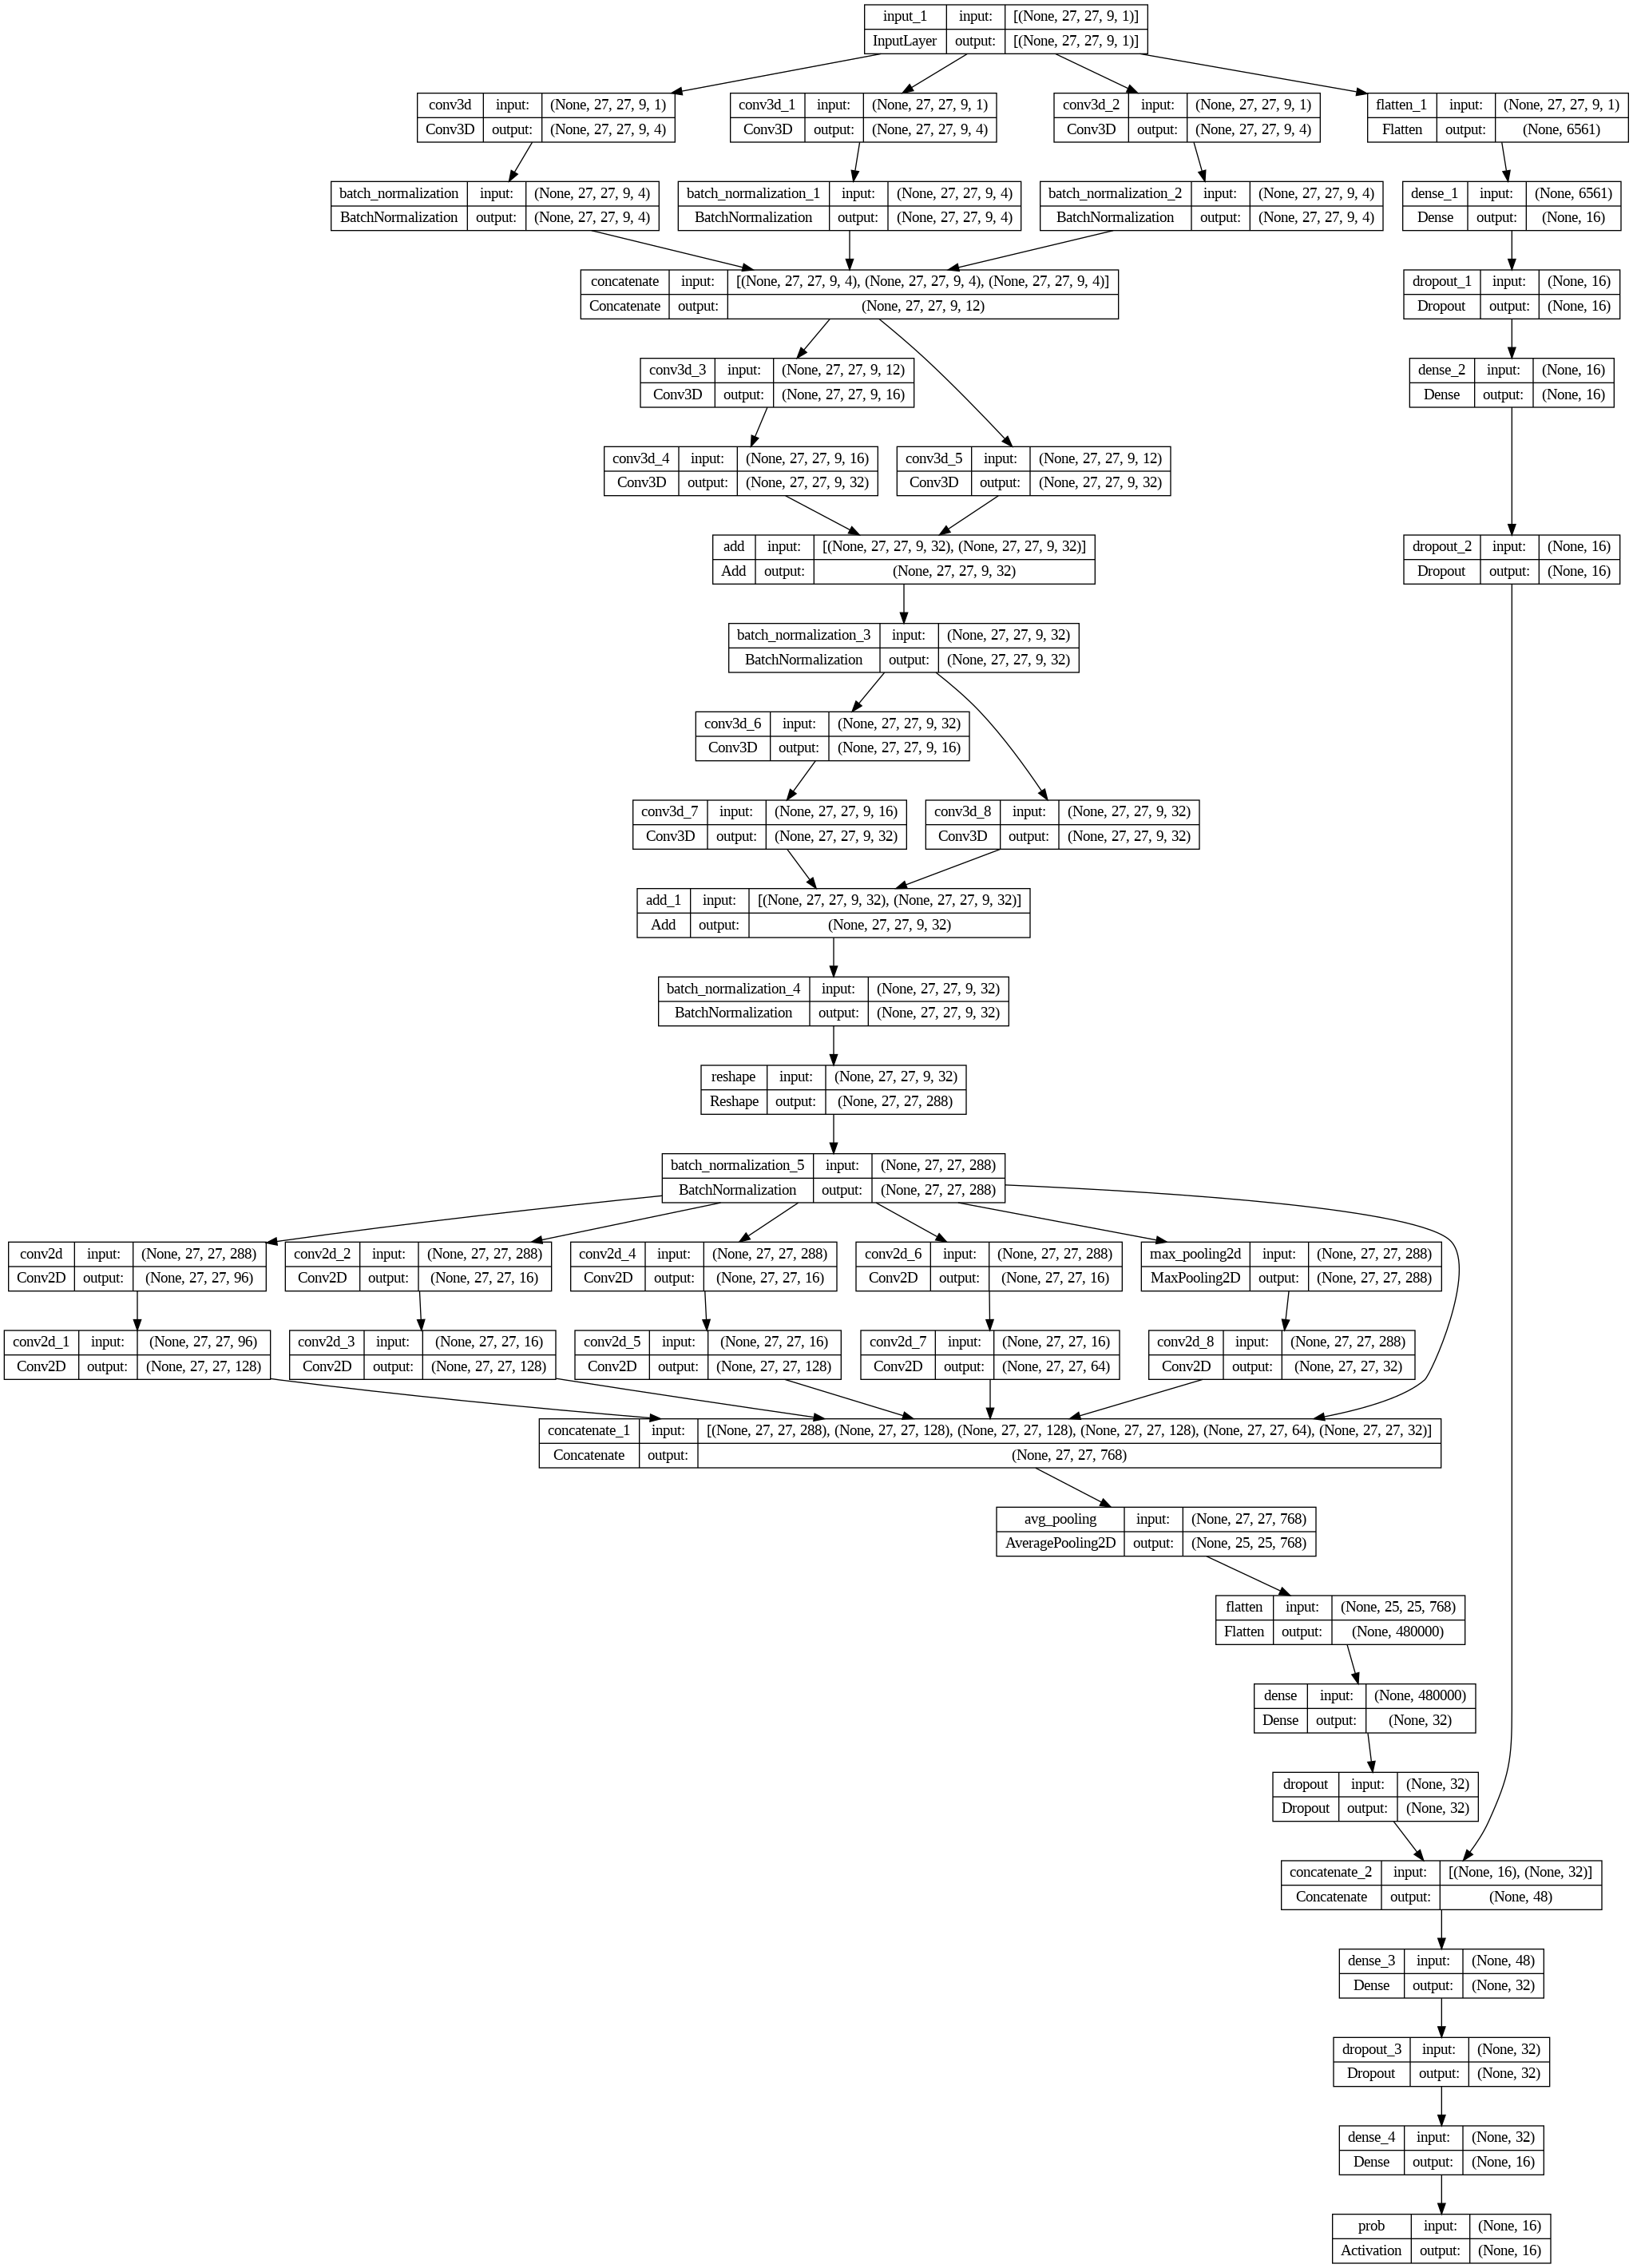

In [ ]:
model.summary()
plot_model(model)
plot_model(model,show_shapes=True, show_layer_names=True)

In [ ]:
# Parallelize if gpus > 1
if (max_gpus>1):
    model = multi_gpu_model(model, gpus=max_gpus)
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=FuncOptimizer, metrics=['accuracy'])

In [ ]:
# Saves the best model, based on accuracy
checkpoint = ModelCheckpoint(best_model, monitor='accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
# If no early stopping desired, skip this cell
early_stop = EarlyStopping( monitor = 'loss',
                           min_delta=0.001,
                           mode='auto',
                           verbose=1, patience=max_patience)
callbacks_list = [checkpoint, early_stop]

In [ ]:
# Summarize configuration
config_txt  = f'Configuration for dataset [{dataset}]:\n\n'
config_txt += f'Test Set Ratio: {test_ratio*100}% of samples\n'
config_txt += f'Window Size   : {window_size} pixels per side\n'
config_txt += f'Dim. Reduction: {dim_reduction} function\n'
config_txt += f'Num channels  : {num_channels} bands after {dim_reduction}\n'
config_txt += '# Network design\n'
config_txt += f'Input shape   : ({window_size}x{window_size}x{num_channels})\n'
config_txt += f'HSI Filters   : {hsi_filters} filters in first layer\n' # 不再需要1x1滤波器
config_txt += f'Internal Size : ({filter_size}x{filter_size}) maximum network filter size\n'
config_txt += '# Training hyperparameters\n'
config_txt += f'Optimizer     : {optimizer_fn}\n'
config_txt += f'Learning rate : {optimizer_lr}\n'
config_txt += f'Batch Size    : {batch_size}\n'
config_txt += f'Num Epochs    : {max_epochs}\n' 
config_txt += f'Patience      : {max_patience}\n'
config_txt += '# Training GPUs\n'
config_txt += f'GPU Maximum   : {max_gpus}\n'
print(config_txt)

Configuration for dataset [IP_99.74]:

Test Set Ratio: 70.0% of samples
Window Size   : 27 pixels per side
Dim. Reduction: fa function
Num channels  : 9 bands after fa
# Network design
Input shape   : (27x27x9)
HSI Filters   : None filters in first layer
Internal Size : (9x9) maximum network filter size
# Training hyperparameters
Optimizer     : adadelta
Learning rate : 0.01
Batch Size    : 106
Num Epochs    : 500
Patience      : 20
# Training GPUs
GPU Maximum   : 1



In [ ]:
# Fit the model keeping the history
history = model.fit(x=Xtrain, y=ytrain, batch_size=batch_size, epochs=max_epochs, callbacks=callbacks_list)

Epoch 1/500
29/29 [==============================] - ETA: 0s - loss: 6.4092 - accuracy: 0.5852
Epoch 1: accuracy improved from -inf to 0.58523, saving model to IP_99.74-best-model.hdf5
29/29 [==============================] - 40s 484ms/step - loss: 6.4092 - accuracy: 0.5852
Epoch 2/500
29/29 [==============================] - ETA: 0s - loss: 2.4760 - accuracy: 0.8328
Epoch 2: accuracy improved from 0.58523 to 0.83279, saving model to IP_99.74-best-model.hdf5
29/29 [==============================] - 14s 468ms/step - loss: 2.4760 - accuracy: 0.8328
Epoch 3/500
29/29 [==============================] - ETA: 0s - loss: 2.2762 - accuracy: 0.8595
Epoch 3: accuracy improved from 0.83279 to 0.85947, saving model to IP_99.74-best-model.hdf5
29/29 [==============================] - 13s 450ms/step - loss: 2.2762 - accuracy: 0.8595
Epoch 4/500
29/29 [==============================] - ETA: 0s - loss: 2.1730 - accuracy: 0.8770
Epoch 4: accuracy improved from 0.85947 to 0.87703, saving model to IP_99.

# Validation

NameError: ignored

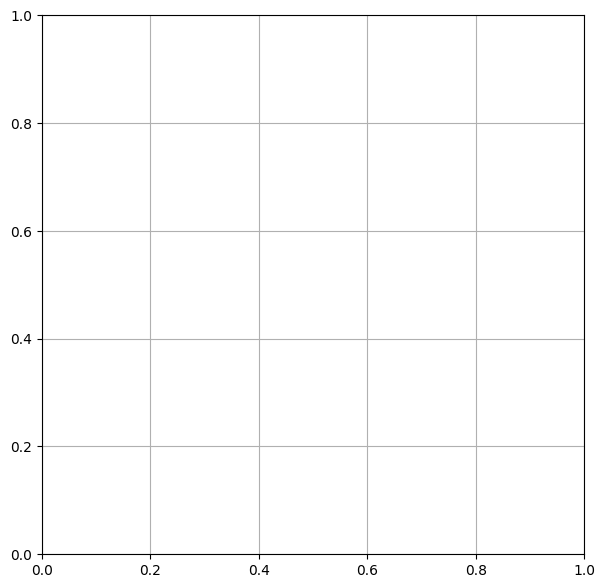

In [ ]:
# Saves, but does not display, the history charts
fig = plt.figure(figsize=(7,7)) 
plt.ioff()
plt.grid() 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig(loss_curve) 
plt.close(fig)

fig = plt.figure(figsize=(7,7)) 
plt.ioff()
plt.ylim(np.min(history.history['accuracy']),1.05) 
plt.grid() 
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig(acc_curve) 
plt.close(fig) 

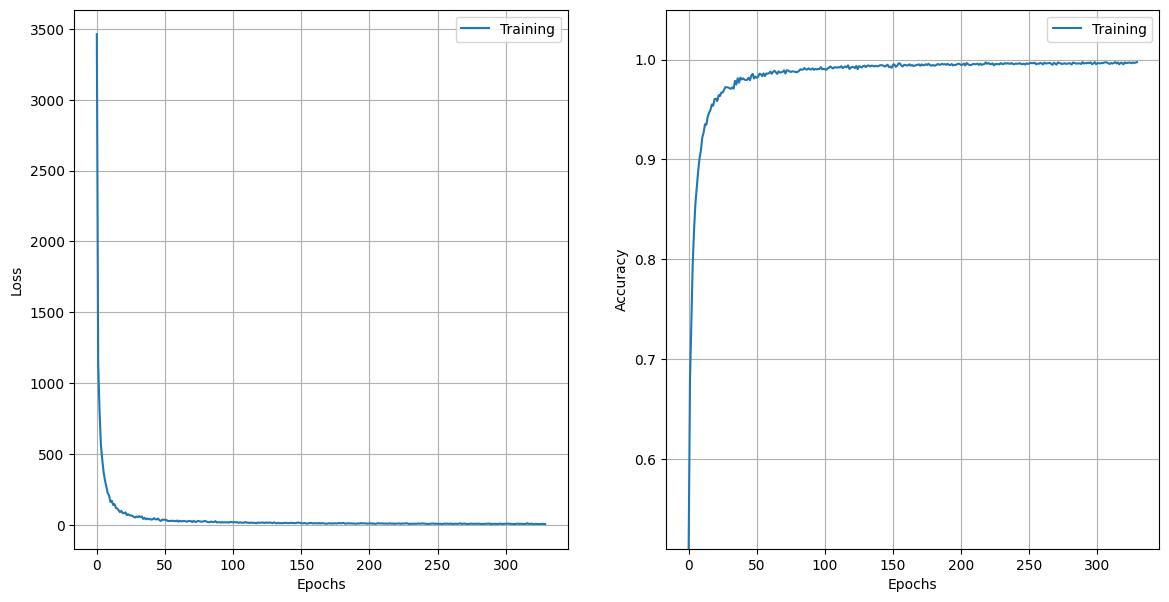

In [ ]:
# Displays history of training
# loss and accuracy by epoch, side by side

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 7))
ax1.grid() 
ax1.plot(history.history['loss'])
ax1.set_ylabel('Loss') 
ax1.set_xlabel('Epochs') 
ax1.legend(['Training','Validation'], loc='upper right') 

ax2.set_ylim(np.min(history.history['accuracy']),1.05) 
ax2.grid() 
ax2.plot(history.history['accuracy'])
ax2.set_ylabel('Accuracy') 
ax2.set_xlabel('Epochs') 
ax2.legend(['Training','Validation']) 
plt.show() # plt.tight_layout()

In [ ]:
# load best weights
model.load_weights(best_model)
model.compile(loss='categorical_crossentropy', optimizer=FuncOptimizer, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, window_size, window_size, num_channels, 1)
Xtest.shape

(7175, 27, 27, 9, 1)

In [ ]:
Ytest = np_utils.to_categorical(ytest)
Ytest.shape

(7175, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)


225/225 [==============================] - 23s 38ms/step


In [ ]:
print(y_pred_test.shape) 
classification = classification_report(np.argmax(Ytest, axis=1), y_pred_test)
print(classification)

(7175,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      0.99      1.00      1000
           2       1.00      1.00      1.00       581
           3       1.00      1.00      1.00       166
           4       1.00      1.00      1.00       338
           5       0.99      1.00      1.00       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00       680
          10       1.00      1.00      1.00      1719
          11       1.00      1.00      1.00       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99        65

    accuracy                           1.00      7175
   macro avg      

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_row_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_row_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def get_targets(name):
    targets_dict = {
        'IP': ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
               'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 
               'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers'],
        'SA': ['Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow', 'Fallow_smooth', 'Stubble',
               'Celery','Grapes_untrained', 'Soil_vinyard_develop', 'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk',
               'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained',
               'Vinyard_vertical_trellis'],
        'PU': ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks',
               'Shadows']
    }
    targets = targets_dict.get(name)
    return (targets)


print(', '.join(get_targets(dataset[0:2].upper())))

def reports (model, X_test, y_test, name, y_pred = None):
    #start = time.time()
    if (y_pred is None):
        Y_pred = model.predict(X_test)
        y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    target_names = get_targets(name[0:2].upper())
    print("Producing report")
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100, target_names

Alfalfa, Corn-notill, Corn-mintill, Corn, Grass-pasture, Grass-trees, Grass-pasture-mowed, Hay-windrowed, Oats, Soybean-notill, Soybean-mintill, Soybean-clean, Wheat, Woods, Buildings-Grass-Trees-Drives, Stone-Steel-Towers


In [ ]:
(classification, confusion, Test_loss, Test_accuracy, 
 oa, each_acc, aa, kappa, target_names) = reports(model, Xtest, Ytest, dataset[0:2], y_pred=y_pred_test)

Producing report
225/225 [==============================] - 10s 41ms/step - loss: 0.1739 - accuracy: 0.9987


In [ ]:
target_performance = 'Accuracy by target:\n'
for (a, b) in zip(target_names, each_acc):
    target_performance += f'{b:8.4f} : {a}\n'
print(target_performance)

Accuracy by target:
100.0000 : Alfalfa
 99.5000 : Corn-notill
100.0000 : Corn-mintill
100.0000 : Corn
100.0000 : Grass-pasture
100.0000 : Grass-trees
100.0000 : Grass-pasture-mowed
100.0000 : Hay-windrowed
 92.8571 : Oats
100.0000 : Soybean-notill
 99.8837 : Soybean-mintill
 99.7590 : Soybean-clean
100.0000 : Wheat
100.0000 : Woods
100.0000 : Buildings-Grass-Trees-Drives
100.0000 : Stone-Steel-Towers



In [ ]:
import seaborn as sns
cf_matrix = np.asarray(confusion)
sns_plot=sns.heatmap(cf_matrix, annot=False, xticklabels=target_names, yticklabels=target_names)
sns_plot.figure.savefig(str(dataset)+'-heatmap.png', dpi=600)
#plt.savefig(str(dataset)+'-heatmap.png')

In [ ]:
classification = str(classification)
confusion = str(confusion)
confusion=confusion.replace('\n', '')
confusion=confusion.replace('] [', ']\n[')
confusion=confusion.replace('][', ']\n[')
dim_reduction='pca'
c_summary = 'Classification Summary\n'
c_summary += f'{Test_loss:7.3f} Test loss (%)\n'
c_summary += f'{Test_accuracy:7.3f} Test accuracy (%)\n'
c_summary += f'{kappa:7.3f} Kappa accuracy (%)\n'
c_summary += f'{oa:7.3f} Overall accuracy (%)\n'
c_summary += f'{aa:7.3f} Average accuracy (%)\n\n'

c_summary += f'{classification}\n\n'
c_summary += f'{confusion}\n\n'

model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x)) # line_length=70,
model_summary = '\n'.join(model_summary)
model_summary += '\n\n'

print(c_summary)
print(target_performance+'\n\n')
print(model_summary)
print(config_txt)

with open(classification_file, 'w') as cs_file:
    cs_file.write(c_summary)
    cs_file.write(target_performance+'\n\n')
    cs_file.write(model_summary)
    cs_file.write(config_txt)

Classification Summary
 17.394 Test loss (%)
 99.875 Test accuracy (%)
 99.857 Kappa accuracy (%)
 99.875 Overall accuracy (%)
 99.500 Average accuracy (%)

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        32
                 Corn-notill       1.00      0.99      1.00      1000
                Corn-mintill       1.00      1.00      1.00       581
                        Corn       1.00      1.00      1.00       166
               Grass-pasture       1.00      1.00      1.00       338
                 Grass-trees       0.99      1.00      1.00       511
         Grass-pasture-mowed       1.00      1.00      1.00        20
               Hay-windrowed       1.00      1.00      1.00       335
                        Oats       1.00      0.93      0.96        14
              Soybean-notill       1.00      1.00      1.00       680
             Soybean-mintill       1.00      1.00      1.00      1719
  

In [ ]:
def Patch(data, height_index, width_index, PATCH_SIZE):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
height = HSI_y.shape[0]

In [ ]:
width  = HSI_y.shape[1]

In [ ]:
X = padWithZeros(DRI, window_size//2)

In [ ]:
X.shape

(171, 171, 9)

In [ ]:
from tqdm import tqdm
# calculate the predicted image
outputs = np.zeros((height,width))
#for i in range(height):
for i in tqdm(range(height), desc="Predicting...",
                          ascii=False, ncols=75):
    for j in range(width):
        target = int(HSI_y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X, i, j, window_size)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2],1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Predicting...:   0%|                               | 0/145 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Predicting...:   1%|▏                      | 1/145 [00:04<10:56,  4.56s/it]

1/1 [==============================] - 0s 39ms/step


Predicting...:   1%|▎                      | 2/145 [00:09<11:49,  4.96s/it]

1/1 [==============================] - 0s 33ms/step


Predicting...:   2%|▍                      | 3/145 [00:15<12:39,  5.35s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:   3%|▋                      | 4/145 [00:21<13:10,  5.61s/it]

1/1 [==============================] - 0s 27ms/step


Predicting...:   3%|▊                      | 5/145 [00:27<13:36,  5.83s/it]

1/1 [==============================] - 0s 20ms/step


Predicting...:   4%|▉                      | 6/145 [00:32<12:37,  5.45s/it]

1/1 [==============================] - 0s 36ms/step


Predicting...:   5%|█                      | 7/145 [00:39<13:37,  5.92s/it]

1/1 [==============================] - 0s 26ms/step


Predicting...:   6%|█▎                     | 8/145 [00:44<13:11,  5.77s/it]

1/1 [==============================] - 0s 33ms/step


Predicting...:   6%|█▍                     | 9/145 [00:50<13:08,  5.80s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:   7%|█▌                    | 10/145 [00:58<14:20,  6.38s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...:   8%|█▋                    | 11/145 [01:03<13:36,  6.09s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:   8%|█▊                    | 12/145 [01:10<13:54,  6.28s/it]

1/1 [==============================] - 0s 27ms/step


Predicting...:   9%|█▉                    | 13/145 [01:15<13:01,  5.92s/it]

1/1 [==============================] - 0s 36ms/step


Predicting...:  10%|██                    | 14/145 [01:24<15:03,  6.89s/it]

1/1 [==============================] - 0s 78ms/step


Predicting...:  10%|██▎                   | 15/145 [01:37<18:33,  8.57s/it]

1/1 [==============================] - 0s 28ms/step


Predicting...:  11%|██▍                   | 16/145 [01:45<18:28,  8.59s/it]

1/1 [==============================] - 0s 37ms/step


Predicting...:  12%|██▌                   | 17/145 [01:55<18:52,  8.85s/it]

1/1 [==============================] - 0s 77ms/step


Predicting...:  12%|██▋                   | 18/145 [02:06<19:57,  9.43s/it]

1/1 [==============================] - 0s 43ms/step


Predicting...:  13%|██▉                   | 19/145 [02:16<20:08,  9.59s/it]

1/1 [==============================] - 0s 42ms/step


Predicting...:  14%|███                   | 20/145 [02:27<21:06, 10.13s/it]

1/1 [==============================] - 0s 31ms/step


Predicting...:  14%|███▏                  | 21/145 [02:33<18:25,  8.91s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  15%|███▎                  | 22/145 [02:38<15:59,  7.80s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  16%|███▍                  | 23/145 [02:43<13:45,  6.76s/it]

1/1 [==============================] - 0s 32ms/step


Predicting...:  17%|███▋                  | 24/145 [02:47<12:27,  6.18s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  17%|███▊                  | 25/145 [02:52<11:16,  5.64s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...:  18%|███▉                  | 26/145 [02:55<09:48,  4.94s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  19%|████                  | 27/145 [02:58<08:35,  4.37s/it]

1/1 [==============================] - 0s 26ms/step


Predicting...:  19%|████▏                 | 28/145 [02:59<06:42,  3.44s/it]

1/1 [==============================] - 0s 33ms/step


Predicting...:  21%|████▌                 | 30/145 [03:03<04:59,  2.61s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  21%|████▋                 | 31/145 [03:09<06:39,  3.50s/it]

1/1 [==============================] - 0s 41ms/step


Predicting...:  22%|████▊                 | 32/145 [03:15<07:55,  4.20s/it]

1/1 [==============================] - 0s 54ms/step


Predicting...:  23%|█████                 | 33/145 [03:24<10:08,  5.43s/it]

1/1 [==============================] - 0s 54ms/step


Predicting...:  23%|█████▏                | 34/145 [03:38<14:33,  7.87s/it]

1/1 [==============================] - 0s 36ms/step


Predicting...:  24%|█████▎                | 35/145 [03:48<15:44,  8.59s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  25%|█████▍                | 36/145 [03:57<15:32,  8.55s/it]

1/1 [==============================] - 0s 27ms/step


Predicting...:  26%|█████▌                | 37/145 [04:06<15:37,  8.68s/it]

1/1 [==============================] - 0s 36ms/step


Predicting...:  26%|█████▊                | 38/145 [04:15<15:41,  8.80s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  27%|█████▉                | 39/145 [04:23<15:22,  8.71s/it]

1/1 [==============================] - 0s 37ms/step


Predicting...:  28%|██████                | 40/145 [04:31<14:29,  8.28s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...:  28%|██████▏               | 41/145 [04:38<13:50,  7.99s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  29%|██████▎               | 42/145 [04:47<14:10,  8.26s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:  30%|██████▌               | 43/145 [04:55<13:52,  8.16s/it]

1/1 [==============================] - 0s 36ms/step


Predicting...:  30%|██████▋               | 44/145 [05:04<14:26,  8.58s/it]

1/1 [==============================] - 0s 28ms/step


Predicting...:  31%|██████▊               | 45/145 [05:17<16:10,  9.70s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  32%|██████▉               | 46/145 [05:24<14:57,  9.07s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:  32%|███████▏              | 47/145 [05:33<14:43,  9.02s/it]

1/1 [==============================] - 0s 54ms/step


Predicting...:  33%|███████▎              | 48/145 [05:41<14:08,  8.74s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  34%|███████▍              | 49/145 [05:51<14:35,  9.12s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  34%|███████▌              | 50/145 [06:00<14:17,  9.03s/it]

1/1 [==============================] - 0s 26ms/step


Predicting...:  35%|███████▋              | 51/145 [06:06<12:39,  8.08s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  36%|███████▉              | 52/145 [06:15<12:51,  8.29s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  37%|████████              | 53/145 [06:22<12:21,  8.06s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:  37%|████████▏             | 54/145 [06:31<12:30,  8.25s/it]

1/1 [==============================] - 0s 39ms/step


Predicting...:  38%|████████▎             | 55/145 [06:40<12:56,  8.63s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...:  39%|████████▍             | 56/145 [06:49<12:37,  8.51s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  39%|████████▋             | 57/145 [06:58<12:46,  8.71s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  40%|████████▊             | 58/145 [07:06<12:20,  8.52s/it]

1/1 [==============================] - 0s 26ms/step


Predicting...:  41%|████████▉             | 59/145 [07:14<11:57,  8.35s/it]

1/1 [==============================] - 0s 33ms/step


Predicting...:  41%|█████████             | 60/145 [07:22<11:47,  8.32s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  42%|█████████▎            | 61/145 [07:30<11:22,  8.13s/it]

1/1 [==============================] - 0s 35ms/step


Predicting...:  43%|█████████▍            | 62/145 [07:37<10:55,  7.90s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  43%|█████████▌            | 63/145 [07:45<10:39,  7.80s/it]

1/1 [==============================] - 0s 35ms/step


Predicting...:  44%|█████████▋            | 64/145 [07:51<09:52,  7.32s/it]

1/1 [==============================] - 0s 31ms/step


Predicting...:  45%|█████████▊            | 65/145 [07:59<09:59,  7.50s/it]

1/1 [==============================] - 0s 36ms/step


Predicting...:  46%|██████████            | 66/145 [08:05<09:20,  7.10s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  46%|██████████▏           | 67/145 [08:12<09:13,  7.10s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  47%|██████████▎           | 68/145 [08:18<08:46,  6.84s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  48%|██████████▍           | 69/145 [08:26<08:56,  7.06s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  48%|██████████▌           | 70/145 [08:32<08:31,  6.82s/it]

1/1 [==============================] - 0s 32ms/step


Predicting...:  49%|██████████▊           | 71/145 [08:40<08:37,  6.99s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  50%|██████████▉           | 72/145 [08:43<07:03,  5.80s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  50%|███████████           | 73/145 [08:45<05:36,  4.67s/it]

1/1 [==============================] - 0s 44ms/step


Predicting...:  51%|███████████▏          | 74/145 [08:51<06:16,  5.30s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  52%|███████████▍          | 75/145 [08:58<06:42,  5.74s/it]

1/1 [==============================] - 0s 34ms/step


Predicting...:  52%|███████████▌          | 76/145 [09:04<06:47,  5.91s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  53%|███████████▋          | 77/145 [09:12<07:06,  6.28s/it]

1/1 [==============================] - 0s 31ms/step


Predicting...:  54%|███████████▊          | 78/145 [09:18<07:02,  6.31s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  54%|███████████▉          | 79/145 [09:27<07:40,  6.98s/it]

1/1 [==============================] - 0s 38ms/step


Predicting...:  55%|████████████▏         | 80/145 [09:33<07:24,  6.83s/it]

1/1 [==============================] - 0s 27ms/step


Predicting...:  56%|████████████▎         | 81/145 [09:41<07:32,  7.07s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  57%|████████████▍         | 82/145 [09:47<07:08,  6.80s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...:  57%|████████████▌         | 83/145 [09:54<06:59,  6.76s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  58%|████████████▋         | 84/145 [09:59<06:24,  6.31s/it]

1/1 [==============================] - 0s 33ms/step


Predicting...:  59%|████████████▉         | 85/145 [10:04<06:07,  6.13s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  59%|█████████████         | 86/145 [10:10<05:56,  6.04s/it]

1/1 [==============================] - 0s 26ms/step


Predicting...:  60%|█████████████▏        | 87/145 [10:15<05:30,  5.70s/it]

1/1 [==============================] - 0s 33ms/step


Predicting...:  61%|█████████████▎        | 88/145 [10:21<05:31,  5.81s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:  61%|█████████████▌        | 89/145 [10:25<04:49,  5.16s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...:  62%|█████████████▋        | 90/145 [10:29<04:17,  4.68s/it]

1/1 [==============================] - 0s 41ms/step


Predicting...:  63%|█████████████▊        | 91/145 [10:32<03:58,  4.42s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...:  63%|█████████████▉        | 92/145 [10:37<03:59,  4.52s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  64%|██████████████        | 93/145 [10:41<03:46,  4.36s/it]

1/1 [==============================] - 0s 28ms/step


Predicting...:  65%|██████████████▎       | 94/145 [10:44<03:23,  4.00s/it]

1/1 [==============================] - 0s 43ms/step


Predicting...:  66%|██████████████▍       | 95/145 [10:48<03:20,  4.00s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  66%|██████████████▌       | 96/145 [10:53<03:30,  4.29s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  67%|██████████████▋       | 97/145 [10:56<03:07,  3.91s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  68%|██████████████▊       | 98/145 [10:59<02:49,  3.62s/it]

1/1 [==============================] - 0s 31ms/step


Predicting...:  68%|███████████████       | 99/145 [11:04<03:01,  3.94s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  69%|██████████████▍      | 100/145 [11:09<03:15,  4.35s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  70%|██████████████▋      | 101/145 [11:14<03:15,  4.45s/it]

1/1 [==============================] - 0s 36ms/step


Predicting...:  70%|██████████████▊      | 102/145 [11:20<03:27,  4.82s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  71%|██████████████▉      | 103/145 [11:24<03:23,  4.83s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  72%|███████████████      | 104/145 [11:29<03:13,  4.72s/it]

1/1 [==============================] - 0s 33ms/step


Predicting...:  72%|███████████████▏     | 105/145 [11:34<03:14,  4.87s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:  73%|███████████████▎     | 106/145 [11:39<03:08,  4.84s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:  74%|███████████████▍     | 107/145 [11:43<02:56,  4.63s/it]

1/1 [==============================] - 0s 35ms/step


Predicting...:  74%|███████████████▋     | 108/145 [11:47<02:48,  4.55s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  75%|███████████████▊     | 109/145 [11:52<02:46,  4.63s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  76%|███████████████▉     | 110/145 [11:56<02:34,  4.41s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  77%|████████████████     | 111/145 [12:00<02:23,  4.21s/it]

1/1 [==============================] - 0s 43ms/step


Predicting...:  77%|████████████████▏    | 112/145 [12:05<02:30,  4.57s/it]

1/1 [==============================] - 0s 31ms/step


Predicting...:  78%|████████████████▎    | 113/145 [12:09<02:22,  4.44s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  79%|████████████████▌    | 114/145 [12:13<02:09,  4.16s/it]

1/1 [==============================] - 0s 34ms/step


Predicting...:  79%|████████████████▋    | 115/145 [12:16<02:00,  4.00s/it]

1/1 [==============================] - 0s 37ms/step


Predicting...:  81%|████████████████▉    | 117/145 [12:17<01:05,  2.34s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  81%|█████████████████    | 118/145 [12:23<01:26,  3.21s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...:  82%|█████████████████▏   | 119/145 [12:28<01:36,  3.71s/it]

1/1 [==============================] - 0s 45ms/step


Predicting...:  83%|█████████████████▍   | 120/145 [12:35<01:51,  4.47s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:  83%|█████████████████▌   | 121/145 [12:40<01:54,  4.76s/it]

1/1 [==============================] - 0s 33ms/step


Predicting...:  84%|█████████████████▋   | 122/145 [12:46<01:56,  5.04s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  85%|█████████████████▊   | 123/145 [12:53<02:03,  5.60s/it]

1/1 [==============================] - 0s 27ms/step


Predicting...:  86%|█████████████████▉   | 124/145 [12:59<01:59,  5.68s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  86%|██████████████████   | 125/145 [13:06<02:02,  6.15s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:  87%|██████████████████▏  | 126/145 [13:10<01:43,  5.43s/it]

1/1 [==============================] - 0s 43ms/step


Predicting...:  88%|██████████████████▍  | 127/145 [13:16<01:42,  5.67s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  88%|██████████████████▌  | 128/145 [13:23<01:41,  5.94s/it]

1/1 [==============================] - 0s 32ms/step


Predicting...:  89%|██████████████████▋  | 129/145 [13:29<01:35,  5.98s/it]

1/1 [==============================] - 0s 32ms/step


Predicting...:  90%|██████████████████▊  | 130/145 [13:36<01:35,  6.37s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:  90%|██████████████████▉  | 131/145 [13:42<01:25,  6.11s/it]

1/1 [==============================] - 0s 30ms/step


Predicting...:  91%|███████████████████  | 132/145 [13:48<01:20,  6.20s/it]

1/1 [==============================] - 0s 22ms/step


Predicting...:  92%|███████████████████▎ | 133/145 [13:54<01:13,  6.09s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...:  92%|███████████████████▍ | 134/145 [13:59<01:04,  5.87s/it]

1/1 [==============================] - 0s 25ms/step


Predicting...:  93%|███████████████████▌ | 135/145 [14:06<01:00,  6.10s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  94%|███████████████████▋ | 136/145 [14:09<00:46,  5.19s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  94%|███████████████████▊ | 137/145 [14:12<00:36,  4.54s/it]

1/1 [==============================] - 0s 33ms/step


Predicting...:  95%|███████████████████▉ | 138/145 [14:17<00:32,  4.66s/it]

1/1 [==============================] - 0s 27ms/step


Predicting...:  96%|████████████████████▏| 139/145 [14:22<00:28,  4.82s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...:  97%|████████████████████▎| 140/145 [14:23<00:19,  3.81s/it]

1/1 [==============================] - 0s 23ms/step


Predicting...:  97%|████████████████████▍| 141/145 [14:25<00:12,  3.09s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  98%|████████████████████▌| 142/145 [14:26<00:07,  2.60s/it]

1/1 [==============================] - 0s 24ms/step


Predicting...:  99%|████████████████████▋| 143/145 [14:27<00:03,  1.93s/it]

1/1 [==============================] - 0s 21ms/step


Predicting...: 100%|█████████████████████| 145/145 [14:27<00:00,  5.98s/it]


/usr/local/lib/python3.9/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


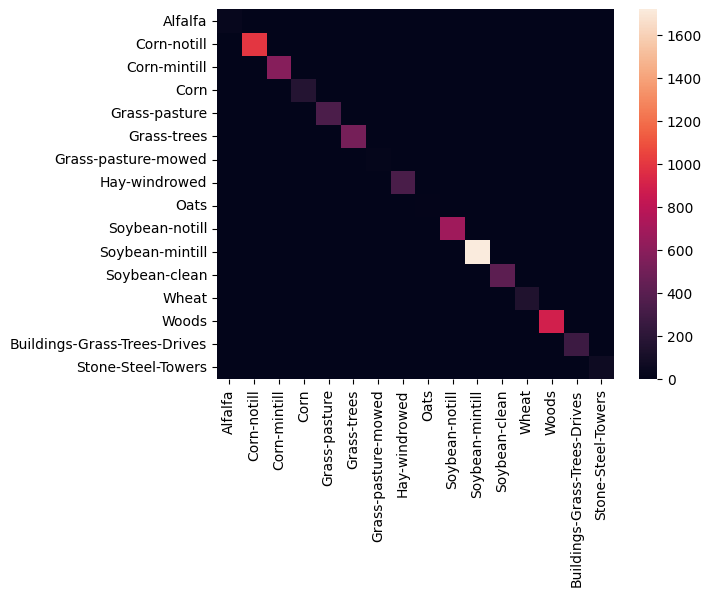

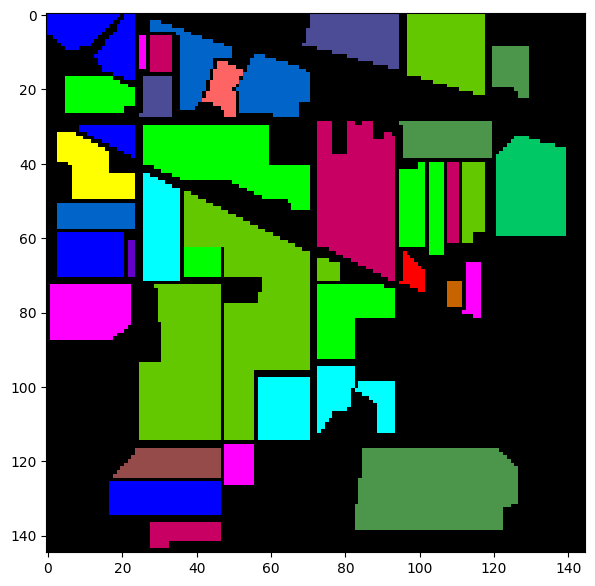

In [ ]:
ground_truth = spectral.imshow(classes = HSI_y,figsize =(7,7))

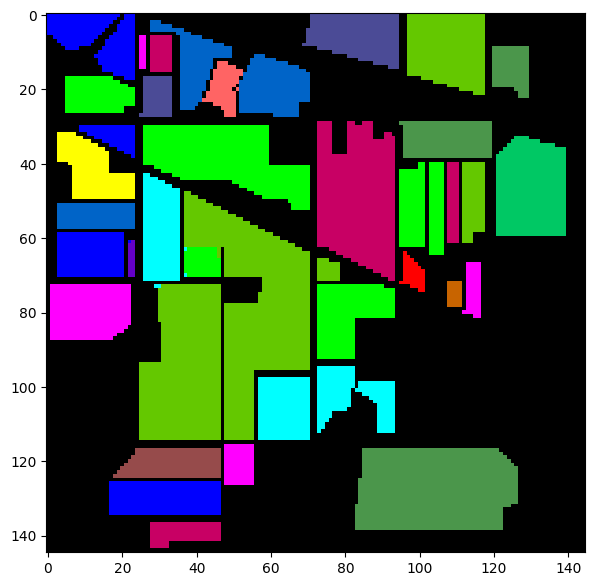

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

Misclassified pixels:  9 / 21025


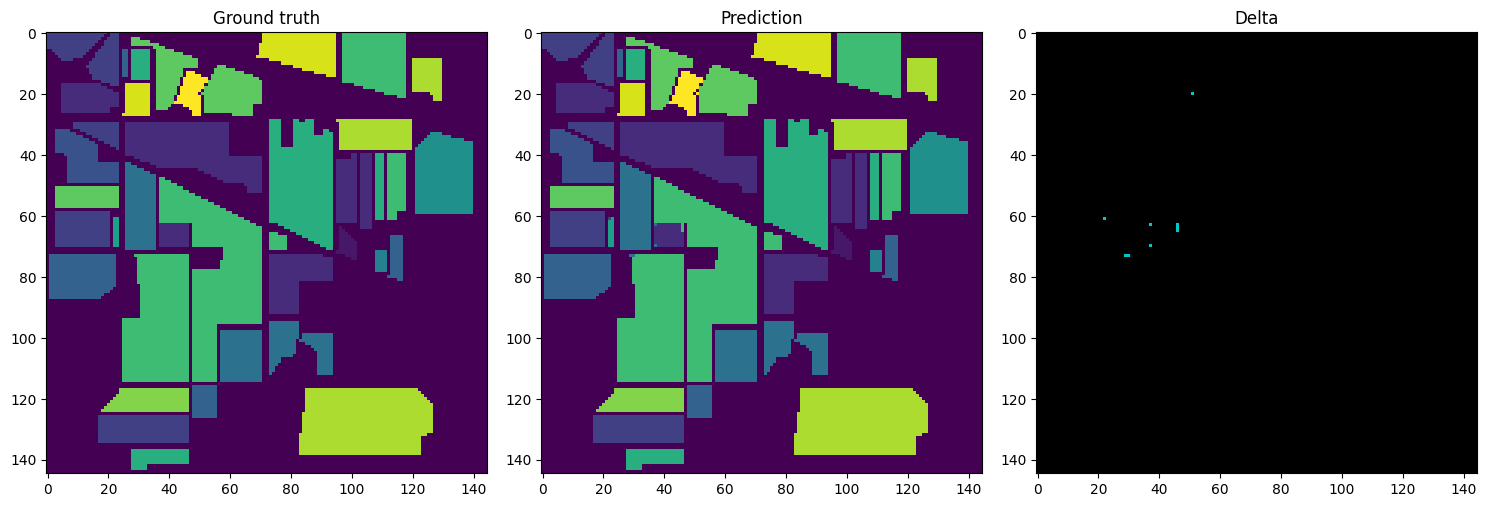

In [ ]:
from matplotlib.colors import ListedColormap, NoNorm

cm = ListedColormap(np.array(spectral.spy_colors)/255.0)
delta = (np.abs(outputs.astype(int) - HSI_y)>0)*1
print('Misclassified pixels: ', np.sum(np.asarray(delta)>0), "/", delta.shape[0]*delta.shape[1])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,8))
ax1.set_title("Ground truth")
ax2.set_title("Prediction")
ax3.set_title("Delta")
ax1.imshow(HSI_y) #, cmap=cm, norm=NoNorm())
ax2.imshow(outputs.astype(int)) #, cmap=cm, norm=NoNorm())
ax3.imshow(delta, cmap=cm)
plt.tight_layout()

In [ ]:
spectral.save_rgb(str(dataset)+"-ground_truth.png", HSI_y, colors=spectral.spy_colors)
spectral.save_rgb(str(dataset)+"-delta.png", delta, colors=spectral.spy_colors)
spectral.save_rgb(predictions_img, outputs.astype(int), colors=spectral.spy_colors)

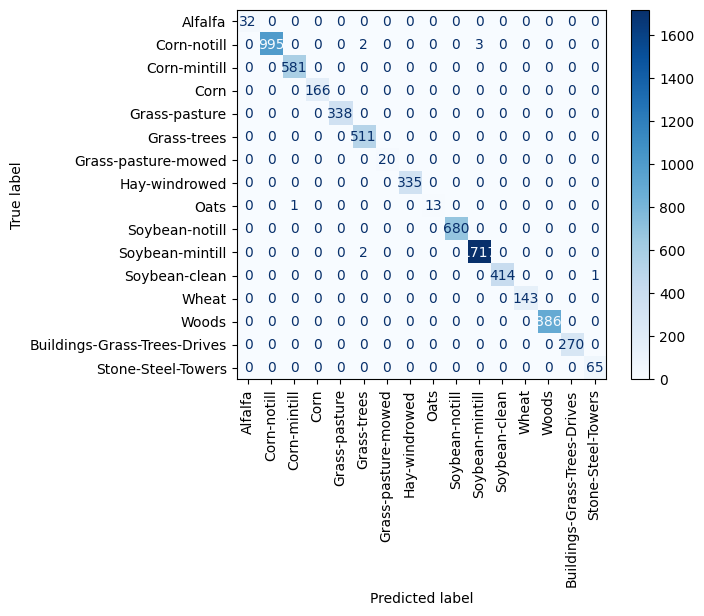

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(np.argmax(Ytest, axis=1), y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers'])
disp.plot(cmap=plt.cm.Blues,xticks_rotation="vertical")

In [ ]:
#del model
#print("Keras Backend RESET")  # optional
#import keras
#import gc
#keras.backend.clear_session()
#tf.keras.backend.clear_session()
#gc.collect()